## Atmospheric River Detection QC  
  
>This notebook performs some basic QC tasks on the AR detection outputs. Select AR event attributes are examined through time and space, and AR event attribute min/mean/max values, distributions, and pairwise relationships are also explored.  
>**Note:** In this notebook the term "AR event" refers only to landfalling AR multipolygons aggregated over adjacent timesteps.  

>Run this notebook after executing the `download.py`  ->  `compute_ivt.py`  ->  `ar_detection.py` pipeline as described in the [repo](https://github.com/ua-snap/ar_avalanche) `README.md`

#### Setup:

Import modules and read in AR data. Prep the AR data for plotting. Define helper functions for QC of attributes and plotting operations.

In [59]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors
from shapely.geometry import Polygon, Point, LineString, shape
import math
import numpy as np

from config import shp_fp, csv_fp, ak_shp, landfall_shp, landfall_csv, landfall_events_shp, landfall_events_csv, start_year, end_year, bbox

In [60]:
#helper function to view & check attributes
def attr_check(shp, tbl):
    pd.set_option('display.max_colwidth', None)
    display(tbl)
    pd.set_option('display.max_colwidth', 150)

    missing = []
    for a in shp.columns.values.tolist():
        if a not in tbl.shp_col.values.tolist():
            missing.append(a)
    
    if len(missing) == 0:
        print("QC passed! Columns in shapefile and table are identical.")
    else:
        print("QC failed! There are some missing columns: ")
        print(missing)

In [61]:
#helper function to count AR data and output narrative descriptions
def count_ars(raw, landfall, events):
    #raw = raw ar detection shp output
    #landfall = landfall ar output
    #events = landfall ar events output
    print("AR detection was performed between " + str(start_year) + " and " + str(end_year) + ", in an area from latitude " + str(bbox[0]) + " to " + str(bbox[2]) + " and longitude " + str(bbox[1]) + " to " + str(bbox[3]) + ".")
    print("\n")
    print("There were " + str(len(raw)) + " individual timestep ARs detected across the entire spatial and temporal domain.")
    print("Of these, " + str(len(landfall)) + " of the detected ARs intersect the Alaska polygon boundary.")
    print("Of these, " + str(len(events)) + " possible AR events were aggregated from landfalling ARs, using a combination of adjacent timesteps and overlapping geometry to define an event.")
    print("\n")
    print("On average, we detected " + str(len(events)/30) + " possible AR events per year.")

In [62]:
# helper function to create a hexagon grid - adapted from https://pygis.io/docs/e_summarize_vector.html
def create_hexgrid(feature, side_length, crs):

    # get extent
    min_x, min_y, max_x, max_y = feature.total_bounds
    # create empty list to hold individual cells that will make up the grid
    cells_list = []
    # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
    x_step = 1.5 * side_length
    # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
    # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
    y_step = math.sqrt(3) * side_length
    # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
    apothem = (math.sqrt(3) * side_length / 2)
    # Set column number
    column_number = 0

    # Create and iterate through list of x values that will define column positions with vertical displacement
    for x in np.arange(min_x, max_x + x_step, x_step):

        # Create and iterate through list of y values that will define column positions with horizontal displacement
        for y in np.arange(min_y, max_y + y_step, y_step):
            # Create hexagon with specified side length
            hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]
            # Append hexagon to list
            cells_list.append(Polygon(hexagon))

        # Check if column number is even
        if column_number % 2 == 0:
            # If even, expand minimum and maximum y values by apothem value to vertically displace next row
            # Expand values so as to not miss any features near the feature extent
            min_y -= apothem
            max_y += apothem

        # Else, odd
        else:
            # Revert minimum and maximum y values back to original
            min_y += apothem
            max_y -= apothem

        # Increase column number by 1
        column_number += 1

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = crs)
    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [63]:
#helper function to group properties by hexgrid cells and aggregate values for plotting
#Note: assumes that full gdf geometry is already reset to represent AR centroid or AR coastal midpoint!

def agg_by_hexgrid_cells(hexgrid, hexid, gdf, prop, agg):
    #hexgrid = gdf of hexgrid used to join centroids/midpoints
    #hexid = unique cell id field in hexgrid gdf (as string, eg "hex_id")
    #gdf = AR events gdf with geometry set to centroid (if polygons) or midpoints (if lines)
    #prop = gdf column with property to aggregate (as string, eg "length")
    #agg = function to use in aggregation (as string, eg "mean")

    #spatial joins to hexgrid (ar centroid counts)
    hexjoin = gpd.sjoin(gdf, hexgrid, how='inner', predicate='intersects')
    #groupby and apply function
    hexjoin_ = hexjoin.groupby(hexid).agg({prop:agg})
    # merge back to grid and fill 0s
    hexgrid_ = hexgrid.merge(hexjoin_, on = hexid, how = "left")
    hexgrid_[prop] = hexgrid_[prop].fillna(0)
    # convert result to integer
    hexgrid_[prop] = hexgrid_[prop].astype(int)

    return hexgrid_

In [64]:
#heatmap plotting function
def plot_heatmaps(gdf, ak_3338, hexdf_full, hexdf_coast, prop, agg, cmap, title, cbar_labels, dev):
    
    # gdf = full events geodataframe
    # ak_3338 = alaska gdf
    # hexdf_full = df with property aggregated by hexbin (full)
    # hexdf_coast = df with property aggregated by hexbin (coast only)
    # prop = property to heatmap
    # agg = aggregation function for temporal heatmap (should map the hexbin df agg function)
    # cmap = matplotlib colormap string
    # title = title for the plot
    # cbar_labels = list of string labels for the colorbar eg ['low', 'high']
    # dev = True or False...if this is a deviation map that should have a white 0 value on colorbar, mark this as True
    
    #data setup
    gdf["Year"] = gdf.start.apply(lambda x: x.year)
    gdf["Month"] = gdf.start.apply(lambda x: x.month)
    pt = gdf.pivot_table(index="Month",columns="Year",values=prop, aggfunc=agg).fillna(0)

    #figure setup
    fig = plt.figure(figsize=(10,9))
    grid = plt.GridSpec(2, 2, wspace=0.05, hspace=-0.35, height_ratios=[1, 2.5], width_ratios=[1,1.66]) 

    heatmap_ax = fig.add_subplot(grid[0, 0:])
    full_ax = fig.add_subplot(grid[1, 0])
    coast_ax = fig.add_subplot(grid[1, 1])

    #colorbar range
    pt_vmax = pt.values.max()
    pt_vmin = 0

    fulldivnorm=mpl_colors.TwoSlopeNorm(vmin=hexdf_full[prop].min(), vcenter=0.01, vmax=hexdf_full[prop].max())
    coastdivnorm=mpl_colors.TwoSlopeNorm(vmin=hexdf_coast[prop].min(), vcenter=0.01, vmax=hexdf_coast[prop].max())

    full_vmax = hexdf_full[prop].max()
    coast_vmax = hexdf_coast[prop].max()

    #plotting
    sns.heatmap(pt, annot=False, ax=heatmap_ax, cmap=cmap, cbar=False, vmax=pt_vmax, vmin=pt_vmin, alpha=0.7)

    ak_3338.geometry.boundary.plot(ax=full_ax, color='black', zorder=1)
    if dev==True:
        hexdf_full.plot(ax=full_ax, column=prop, cmap=cmap, norm=fulldivnorm, legend=False, edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, zorder=2)
    else:
        hexdf_full.plot(ax=full_ax, column=prop, cmap=cmap, vmin=0, vmax=full_vmax, legend=False, edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, zorder=2)
    full_ax.set_xlim([-2250000, 1750000])
    full_ax.set_ylim([-1500000, 2250000])

    ak_3338.geometry.boundary.plot(ax=coast_ax, color='black', zorder=1)
    if dev==True:
        hexdf_coast.plot(ax=coast_ax, column=prop, cmap=cmap, norm=coastdivnorm, legend = False, edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, zorder=2)
    else:
        hexdf_coast.plot(ax=coast_ax, column=prop, cmap=cmap, vmin=0, vmax=coast_vmax, legend = False, edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, zorder=2)
    coast_ax.set_xlim([-2250000, 1750000])
    coast_ax.set_ylim([0, 2250000])

    #formatting axes and text
    f = 8
    heatmap_ax.set(xlabel=None, ylabel=None)
    heatmap_ax.xaxis.tick_top()
    heatmap_ax.xaxis.set_tick_params(labeltop=True, size=0)
    heatmap_ax.xaxis.set_tick_params(labelbottom=False)
    heatmap_ax.set_xticklabels(labels=[str(y) for y in pt.columns.to_list()], rotation=45, fontsize=f)
    heatmap_ax.set_yticklabels(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'], rotation=0, fontsize=f, ha='right')
    #heatmap_ax.set_yticklabels([str(m) for m in pt.index.to_list()],rotation=0, fontsize=f, ha='center')#keep to change to numeric months

    plt.setp(full_ax, yticks=[], xticks=[])
    plt.setp(coast_ax, yticks=[], xticks=[])

    #color bar
    colorbar = fig.colorbar(heatmap_ax.collections[0], location='top', ticks=[pt_vmin, pt_vmax], shrink=.35, pad=0.18)
    colorbar.set_ticklabels([cbar_labels[0], cbar_labels[1]], fontsize=f-1, fontstyle='italic')
    colorbar.outline.set_linewidth(0)
    colorbar.ax.tick_params(size=0)

    #titles
    full_ax.set_title('Event Centroids', y=-0.1, fontsize=f+1)
    coast_ax.set_title('Coastal Impact Points', y=-0.1, fontsize=f+1)
    fig.suptitle(title, y=.895, fontsize=f+3)

    plt.show()

In [65]:
#import raw AR shapefile/csv and convert time to datetime
raw = gpd.read_file(shp_fp)
raw['time'] = pd.to_datetime(raw['time'])
raw_csv = pd.read_csv(csv_fp)

#read AR landfall shapefile/csv and convert time to datetime
landfall = gpd.read_file(landfall_shp)
landfall['time'] = pd.to_datetime(landfall['time'])
landfall_csv_ = pd.read_csv(landfall_csv)

#read AR events shapefile/csv and convert start/end to datetime
events = gpd.read_file(landfall_events_shp)
events['start'] = pd.to_datetime(events['start'])
events['end'] = pd.to_datetime(events['end'])
events_csv = pd.read_csv(landfall_events_csv)

#assign general "gdf" variable from the events layer for plotting
gdf = events.copy()

#calculate relative intensity deviation; this is the difference between an event's intensity and the entire dataset mean intensity
gdf['rintensity_dev'] = gdf['rintensity'] - gdf['rintensity'].mean()
#calculate duration deviation; this is the difference between an event's duration and the entire dataset mean duration
gdf['dur_hrs_dev'] = gdf['dur_hrs'] - gdf['dur_hrs'].mean()
#calculate length deviation; this is the difference between an event's length and the entire dataset mean length
gdf['length_dev'] = gdf['len_km_m'] - gdf['len_km_m'].mean()
#calculate directional coherence deviation; this is the difference between an event's directional coherence and the entire dataset mean directional coherence
gdf['dircoher_dev'] = gdf['dircoher_m'] - gdf['dircoher_m'].mean()


#add count of 1 to each event to use in count agg functions
gdf['count'] = 1

#import ak shp (already in 3338) and reproject gdf layer to to 3338
ak_3338 = gpd.read_file(ak_shp)
gdf_3338 = gdf.to_crs(ak_3338.crs)

#create simple line to represent southern AK coast boundary
lonlats = {173:52.5, 178.5:51.5, -176:52, -173:52, -164:54, -153:57, -151:59, -147:60, -141:60, -137:58, -133:55}
df = pd.DataFrame.from_dict(lonlats, orient='index').reset_index().rename(columns={'index':'X', 0:'Y'})
#zip the coords into a point object and convert to gdf
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df['id'] = 'ak_coast'
#use the points in order to create a linestring
geo_df2 = geo_df.groupby('id')['geometry'].apply(lambda x: LineString(x.tolist()))
#convert to geodataframe and add CRS, then convert CRS to 3338
ak_coast = gpd.GeoDataFrame(geo_df2, geometry='geometry', crs=gdf.crs)
ak_coast_3338 = ak_coast.to_crs(ak_3338.crs)

#perform overlay analysis to highlight just parts of AR polygons intersecting coast
gdf_ak_int = ak_coast_3338.overlay(gdf_3338, how='intersection', keep_geom_type=True)
#explode overlay result into individual line segments to account for ARs with multiple polygon parts intersecting coast
gdf_ak_int = gdf_ak_int.explode(index_parts=False)
#get midpoints of each linestring and reset geometry; this layer now contains approximated impact points on coast for each AR event
gdf_ak_int['midpoints'] = gdf_ak_int.geometry.apply(lambda x: x.line_interpolate_point(.5, normalized=True))
gdf_ak_int = gdf_ak_int.set_geometry(gdf_ak_int['midpoints'])

#reset gdf_3338 geometries to centroid and create new gdf for hexgrid plots
gdf_3338_c = gdf_3338.copy()
gdf_3338_c['geom'] = gdf_3338_c.geometry.centroid
gdf_3338_c = gdf_3338_c.set_geometry('geom')

#create hexgrid and aggregate various properties....many of these are not used in the plots, but could be explored!
hexgrid = create_hexgrid(gdf_3338, 70000, gdf_3338.crs)


centroid_counts = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'count', 'sum')

centroid_mean_duration = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dur_hrs', 'mean')
centroid_max_duration = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dur_hrs', 'max')
centroid_mean_duration_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dur_hrs_dev', 'mean')
centroid_max_duration_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dur_hrs_dev', 'max')

centroid_mean_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity', 'mean')
centroid_max_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity', 'max')
centroid_mean_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity_dev', 'mean')
centroid_max_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity_dev', 'max')

centroid_mean_length = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'len_km_m', 'mean')
centroid_max_length = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'len_km_m', 'max')
centroid_mean_length_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'length_dev', 'mean')
centroid_max_length_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'length_dev', 'max')

centroid_mean_dircoher = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dircoher_m', 'mean')
centroid_max_dircoher = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dircoher_m', 'max')
centroid_mean_dircoher_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dircoher_dev', 'mean')
centroid_max_dircoher_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'dircoher_dev', 'max')


coast_counts = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'count', 'sum')

coast_mean_duration = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dur_hrs', 'mean')
coast_max_duration = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dur_hrs', 'max')
coast_mean_duration_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dur_hrs_dev', 'mean')
coast_max_duration_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dur_hrs_dev', 'max')

coast_mean_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity', 'mean')
coast_max_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity', 'max')
coast_mean_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity_dev', 'mean')
coast_max_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity_dev', 'max')

coast_mean_length = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'len_km_m', 'mean')
coast_max_length = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'len_km_m', 'max')
coast_mean_length_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'length_dev', 'mean')
coast_max_length_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'length_dev', 'max')

coast_mean_dircoher = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dircoher_m', 'mean')
coast_max_dircoher = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dircoher_m', 'max')
coast_mean_dircoher_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dircoher_dev', 'mean')
coast_max_dircoher_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'dircoher_dev', 'max')

#### General Dataset Information:

In [66]:
count_ars(raw, landfall, events)

AR detection was performed between 1992 and 2022, in an area from latitude 10 to 66 and longitude -179 to -120.


There were 19146 individual timestep ARs detected across the entire spatial and temporal domain.
Of these, 8293 of the detected ARs intersect the Alaska polygon boundary.
Of these, 1802 possible AR events were aggregated from landfalling ARs, using a combination of adjacent timesteps and overlapping geometry to define an event.


On average, we detected 60.06666666666667 possible AR events per year.


#### Check attributes:    

View column description CSV for each output dataset, and check that the columns in the shapefile output and CSV output are identical.

In [67]:
attr_check(raw, raw_csv)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


QC passed! Columns in shapefile and table are identical.


In [68]:
attr_check(landfall, landfall_csv_)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


QC passed! Columns in shapefile and table are identical.


In [69]:
attr_check(events, events_csv)

,shp_col,desc
0,event_id,unique AR event ID
1,geometry,geometry string for AR event polygons
2,start,first timestep of AR event
3,end,last timestep of AR event
4,sumtot_str,sum of IVT across all timestep ARs in event
5,sumrel_str,sum of relative IVT (sum IVT/area) across all timestep ARs in event
6,ratio_m,mean length to width ratio across all timestep ARs in event
7,len_km_m,mean length (km) across all timestep ARs in event
8,orient_m,mean orientation across all timestep ARs in event
9,poleward_m,mean poleward strength across all timestep ARs in event


QC passed! Columns in shapefile and table are identical.


#### General AR Property Distributions and Pairwise Relationships

View AR property distribution statistics, and make some adjustments before plotting.

As you can see, there are some substantial outliers in duration and length/width ratio properties. According to [this](https://www.jpl.nasa.gov/news/ranking-atmospheric-rivers-new-study-finds-world-of-potential#:~:text=mean%20lifetime%20was%20about%2017%20hours%20for%20AR%201%20and%20110%20hours%20for%20AR%205.) reference, even the strongest AR events have a mean duration of 110 hrs. Our aggregation of individual timestep ARs into events may have 'over aggregated' and created some unreasonably long events. For now, we will remove events with >125 hrs duration (n = 110) and plot properties of the rest of the dataset, and note that event aggregation needs to be improved.

How to read the Pairplot: Orange plots (from upper-left to lower-right diagonal) show univariate distributions for each AR property. These are standard histograms with an overlaid density curve. All other plots show pairwise relationships between AR properties. The blue plots on the lower left of the figure show 2-D kernel density estimation, and purple plots on the upper right show a standard scatterplot of all observations.

Text(0.5, 0.95, 'AR event properties: min, mean, max (1992-2022)\nn = 1802')

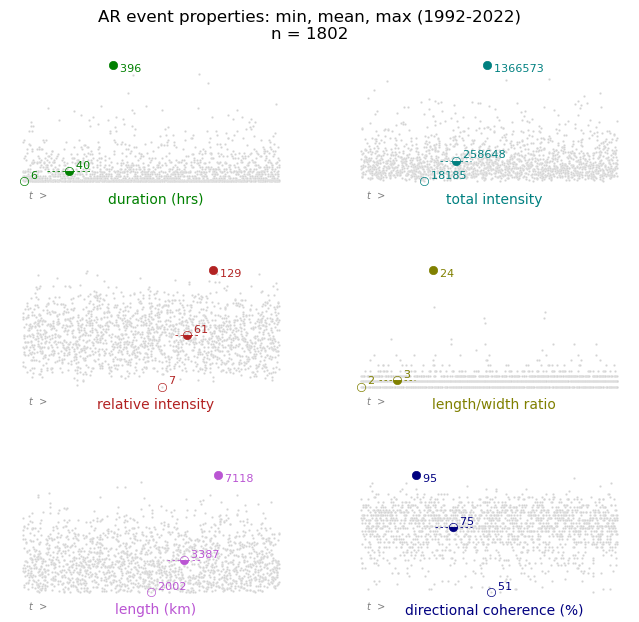

In [70]:
#subset attributes, including time for x-axis
#define easier-to-read titles (excluding time attribute)
sub = gdf[['start', 'dur_hrs', 'tintensity', 'rintensity', 'ratio_m', 'len_km_m', 'dircoher_m']].copy()
titles = ['duration (hrs)', 'total intensity', 'relative intensity', 'length/width ratio', 'length (km)', 'directional coherence (%)']

#setup plot and axes
fig, axes = plt.subplots(int(len(sub.drop(columns='start').columns)/2), 2, sharex=False, figsize=(8, 7))
plt.subplots_adjust(hspace = 0.6)
sns.set_style("white")
sns.despine(fig=fig, ax=axes, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

#define color pairs....must be the same # of pairs as # of non-time attributes
colors = ['green', 'teal', 'firebrick', 'olive', 'mediumorchid', 'navy']
#set fontsize for attr text
f = 8

#loop thru attributes and plot
for attr, ax, t, c in zip(sub.drop(columns='start').columns.values.tolist(), fig.axes, titles, colors):
    #get stats
    a_min, a_mean, a_max = sub[attr].values.min(), sub[attr].values.mean(), sub[attr].values.max()
    #get time values for each stat
    a_min_idx, a_max_idx = sub[attr].idxmin(), sub[attr].idxmax()
    min_t, max_t = sub['start'].iloc[sub[attr].idxmin()], sub['start'].iloc[sub[attr].idxmax()]
    #mean time value will just be the midpoint between min and max
    mean_t = min_t + (max_t - min_t) / 2 
    #set time values for mean line extension; use 25% of distance between min_t and max_t
    mean_t_low = min_t + (max_t - min_t) / 4
    mean_t_high = max_t - (max_t - min_t) / 4
    #plot data cloud and mean line extension
    sns.scatterplot(ax=ax, data=sub, x='start', y=attr, color='lightgray', s=2.75)
    sns.lineplot(ax=ax, x=[mean_t_low, mean_t, mean_t_high], y=[a_mean, a_mean, a_mean], color=c, linewidth=.6, linestyle=(0, (3,3)))
    #plot min/mean/max points
    ax.plot(min_t, a_min, marker='o', fillstyle='none', markeredgewidth= .5, c=c)
    ax.plot(max_t, a_max, marker='o', fillstyle='full', markeredgewidth= .5, c=c)
    ax.plot(mean_t, a_mean, marker='o', fillstyle='bottom', markeredgewidth= .5, c=c)
    #define relative nudge distance for point labels (divides the y-axis into 50 parts)
    nudge = (a_max - a_min)/50
    #add point labels, with nudge for formatting
    ax.text(x = min_t, y = a_min + nudge, s = str("  " + str(int(a_min))), color = c, fontsize=f)
    ax.text(x = max_t, y = a_max - nudge*3, s = str("  " + str(int(a_max))), color = c, fontsize=f)
    ax.text(x = mean_t, y = a_mean + nudge, s = str("  " + str(int(a_mean))), color = c, fontsize=f)
    #adjust axis labels
    ax.set_ylabel(t, rotation=0, labelpad=-105, color=c, fontsize=f+2, y=-0.15)
    ax.set_xlabel('t  >', rotation=0, labelpad=3, color='gray', fontsize=f-1, style='italic', x=0.1)
#remove axes ticks and add title    
plt.setp(axes, yticks=[], xticks=[])
fig.suptitle(('AR event properties: min, mean, max (' + str(start_year) + '-' + str(end_year) + ')\nn = ' + str(len(gdf))), color='black', fontsize=f+4, y=.95)

In [71]:
#remove outliers and redefine master gdf
gdf = gdf[gdf['dur_hrs']<125].copy()

Text(0.5, 0.95, 'AR event properties: min, mean, max (1992-2022)\nn = 1692')

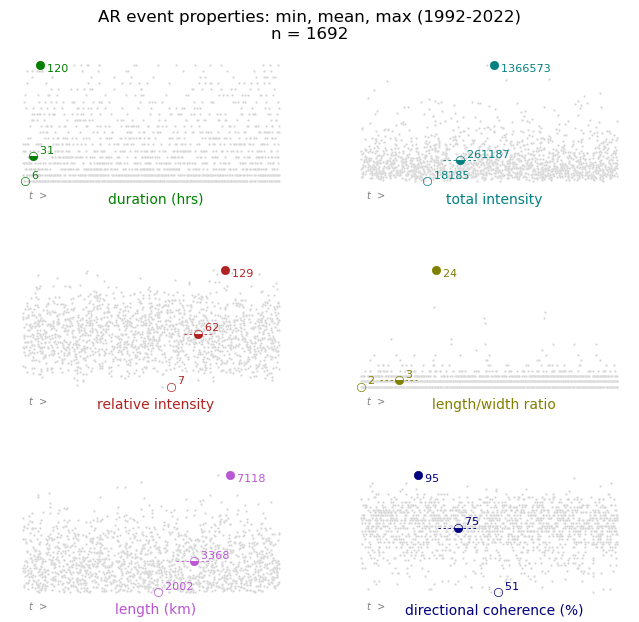

In [72]:
#subset attributes, including time for x-axis
#define easier-to-read titles (excluding time attribute)
sub = gdf[['start', 'dur_hrs', 'tintensity', 'rintensity', 'ratio_m', 'len_km_m', 'dircoher_m']].copy()
titles = ['duration (hrs)', 'total intensity', 'relative intensity', 'length/width ratio', 'length (km)', 'directional coherence (%)']

#setup plot and axes
fig, axes = plt.subplots(int(len(sub.drop(columns='start').columns)/2), 2, sharex=False, figsize=(8, 7))
plt.subplots_adjust(hspace = 0.6)
sns.set_style("white")
sns.despine(fig=fig, ax=axes, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

#define color pairs....must be the same # of pairs as # of non-time attributes
colors = ['green', 'teal', 'firebrick', 'olive', 'mediumorchid', 'navy']
#set fontsize for attr text
f = 8

#loop thru attributes and plot
for attr, ax, t, c in zip(sub.drop(columns='start').columns.values.tolist(), fig.axes, titles, colors):
    #get stats
    a_min, a_mean, a_max = sub[attr].values.min(), sub[attr].values.mean(), sub[attr].values.max()
    #get time values for each stat
    a_min_idx, a_max_idx = sub[attr].idxmin(), sub[attr].idxmax()
    min_t, max_t = sub['start'].iloc[sub[attr].idxmin()], sub['start'].iloc[sub[attr].idxmax()]
    #mean time value will just be the midpoint between min and max
    mean_t = min_t + (max_t - min_t) / 2 
    #set time values for mean line extension; use 25% of distance between min_t and max_t
    mean_t_low = min_t + (max_t - min_t) / 4
    mean_t_high = max_t - (max_t - min_t) / 4
    #plot data cloud and mean line extension
    sns.scatterplot(ax=ax, data=sub, x='start', y=attr, color='lightgray', s=2.75)
    sns.lineplot(ax=ax, x=[mean_t_low, mean_t, mean_t_high], y=[a_mean, a_mean, a_mean], color=c, linewidth=.6, linestyle=(0, (3,3)))
    #plot min/mean/max points
    ax.plot(min_t, a_min, marker='o', fillstyle='none', markeredgewidth= .5, c=c)
    ax.plot(max_t, a_max, marker='o', fillstyle='full', markeredgewidth= .5, c=c)
    ax.plot(mean_t, a_mean, marker='o', fillstyle='bottom', markeredgewidth= .5, c=c)
    #define relative nudge distance for point labels (divides the y-axis into 50 parts)
    nudge = (a_max - a_min)/50
    #add point labels, with nudge for formatting
    ax.text(x = min_t, y = a_min + nudge, s = str("  " + str(int(a_min))), color = c, fontsize=f)
    ax.text(x = max_t, y = a_max - nudge*3, s = str("  " + str(int(a_max))), color = c, fontsize=f)
    ax.text(x = mean_t, y = a_mean + nudge, s = str("  " + str(int(a_mean))), color = c, fontsize=f)
    #adjust axis labels
    ax.set_ylabel(t, rotation=0, labelpad=-105, color=c, fontsize=f+2, y=-0.15)
    ax.set_xlabel('t  >', rotation=0, labelpad=3, color='gray', fontsize=f-1, style='italic', x=0.1)
#remove axes ticks and add title    
plt.setp(axes, yticks=[], xticks=[])
fig.suptitle(('AR event properties: min, mean, max (' + str(start_year) + '-' + str(end_year) + ')\nn = ' + str(len(gdf))), color='black', fontsize=f+4, y=.95)

Text(0.5, 1.01, 'Pairplot of AR Event Properties')

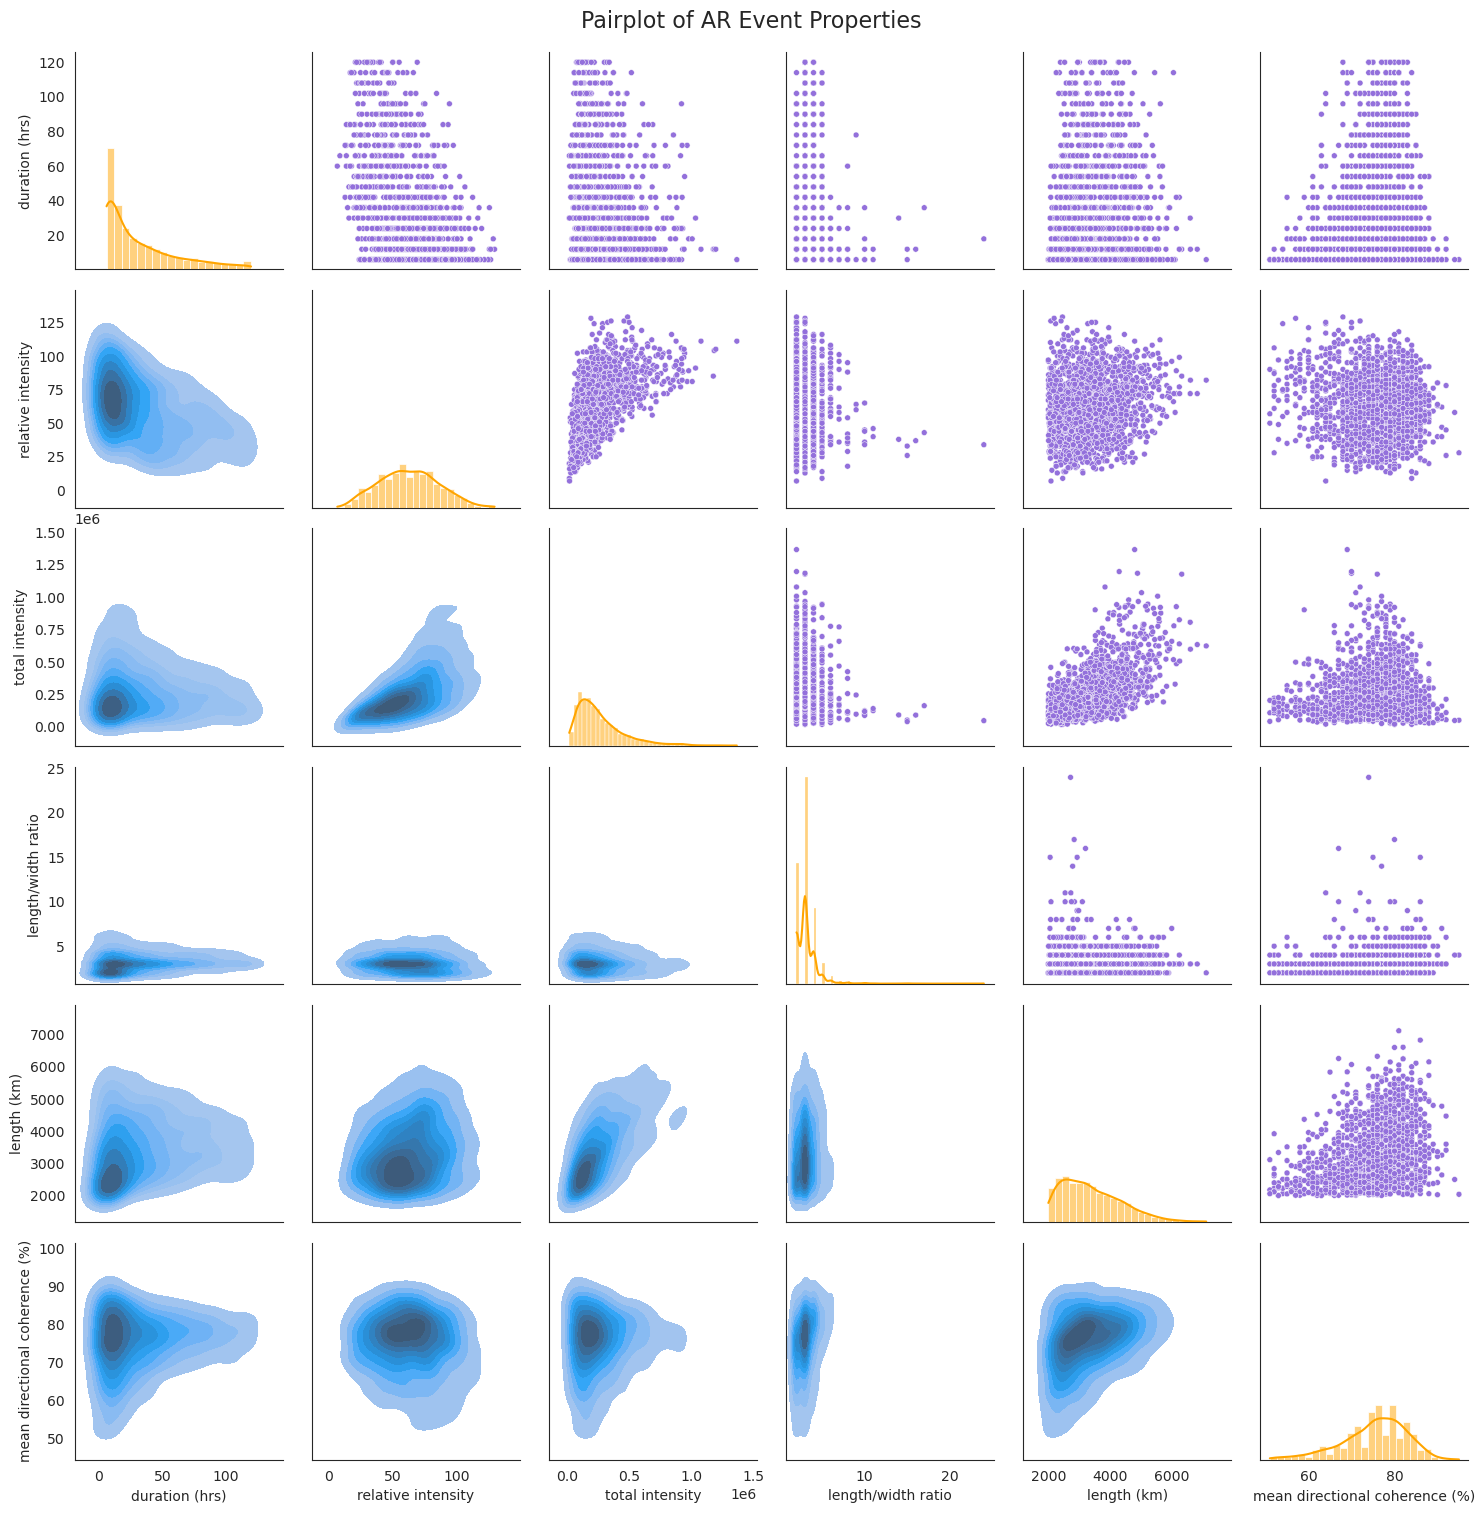

In [73]:
sub = gdf[['dur_hrs', 'rintensity', 'tintensity', 'ratio_m', 'len_km_m', 'dircoher_m']].copy()
sub.rename(columns={'dur_hrs':'duration (hrs)', 'rintensity':'relative intensity', 'tintensity':'total intensity', 'ratio_m':'length/width ratio', 'len_km_m':'length (km)', 'dircoher_m':'mean directional coherence (%)'}, inplace=True)
sns.set_style("white")

g = sns.PairGrid(sub)
g.map_upper(sns.scatterplot, size=0.1, color='mediumpurple')
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='orange')

g.fig.suptitle('Pairplot of AR Event Properties', y=1.01, fontsize=16)

#### Temporal and Spatial Heatmaps:

View aggregated AR event properties in time and space. Do the extremes match the timing of other atmospheric phenomena (ie el Nino/la Nina, PDO, etc)? Do the extremes match known AR spatial distribution?

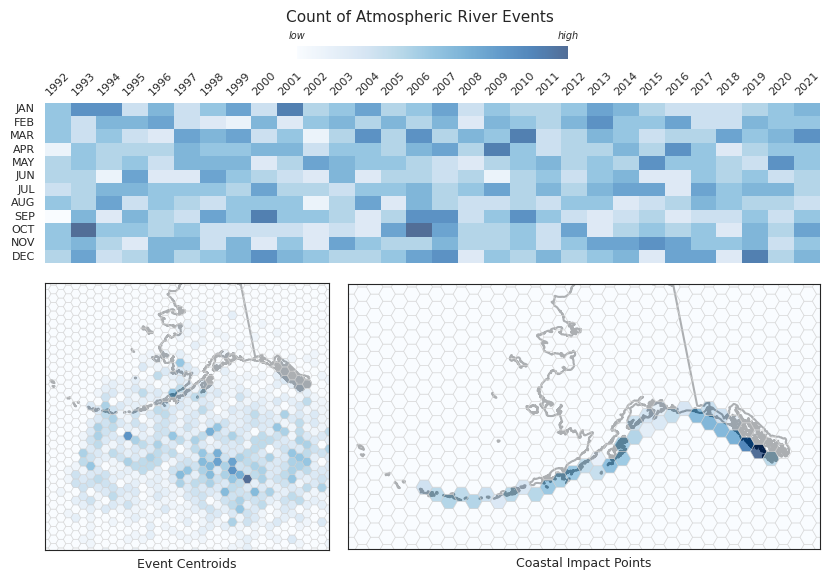

In [74]:
plot_heatmaps(gdf, ak_3338, centroid_counts, coast_counts, 'count', 'count', 'Blues', 'Count of Atmospheric River Events', ['low', 'high'], dev=False)

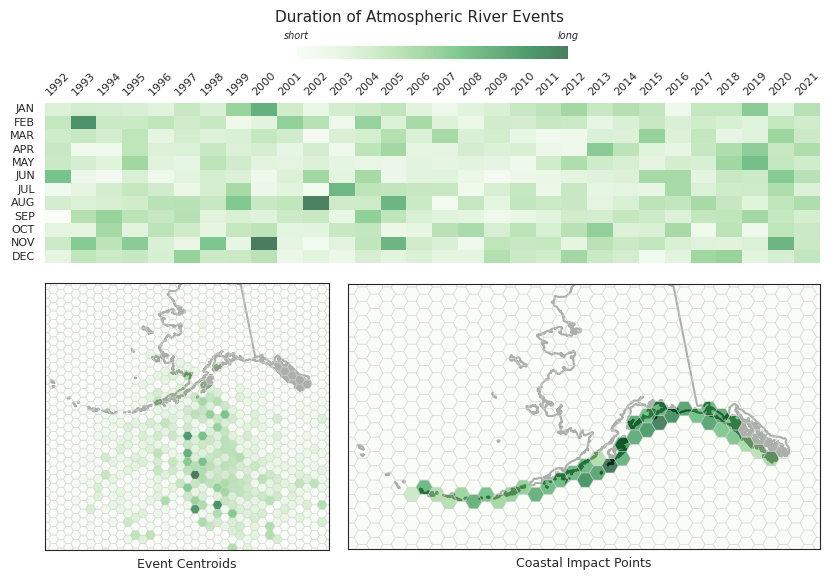

In [75]:
plot_heatmaps(gdf, ak_3338, centroid_mean_duration, coast_mean_duration, 'dur_hrs', 'mean', 'Greens', 'Duration of Atmospheric River Events', ['short', 'long'], dev=False)

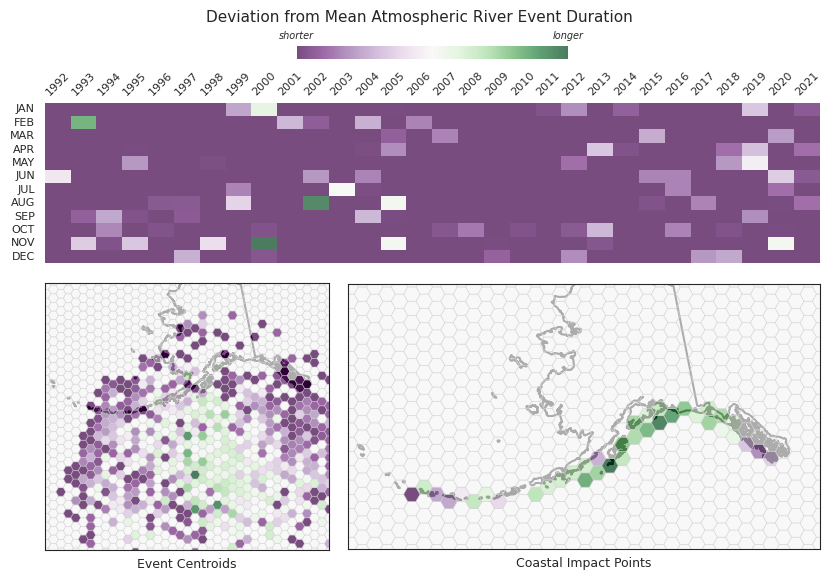

In [76]:
plot_heatmaps(gdf, ak_3338, centroid_mean_duration_deviation, coast_mean_duration_deviation, 'dur_hrs_dev', 'mean', 'PRGn', 'Deviation from Mean Atmospheric River Event Duration', ['shorter', 'longer'], dev=True)

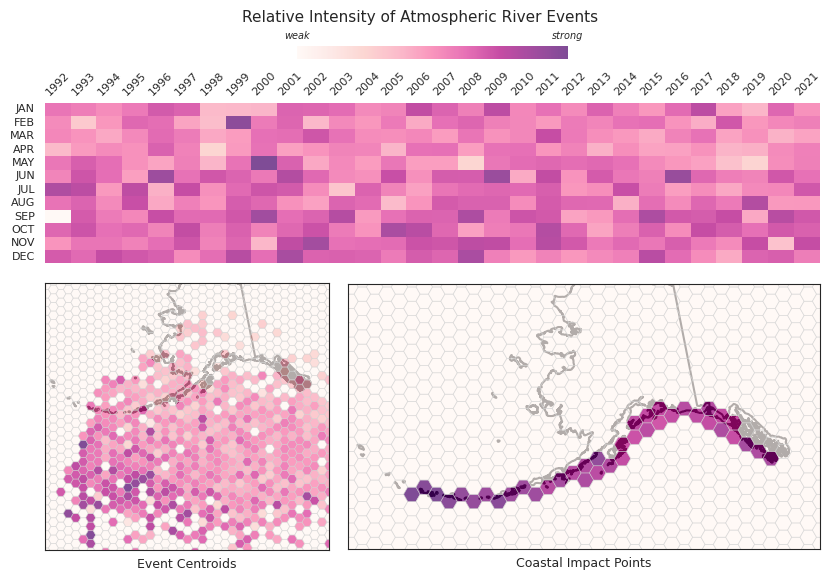

In [77]:
plot_heatmaps(gdf, ak_3338, centroid_mean_intensity, coast_mean_intensity, 'rintensity', 'mean', 'RdPu', 'Relative Intensity of Atmospheric River Events', ['weak', 'strong'], dev=False)

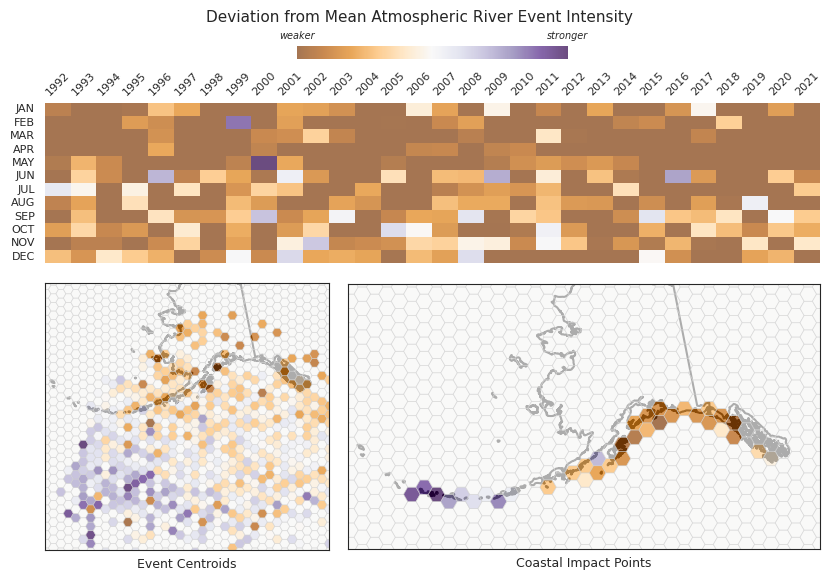

In [78]:
plot_heatmaps(gdf, ak_3338, centroid_mean_intensity_deviation, coast_mean_intensity_deviation, 'rintensity_dev', 'mean', 'PuOr', 'Deviation from Mean Atmospheric River Event Intensity', ['weaker', 'stronger'], dev=True)

#### Note on Heatmap Methodology:
  
Coastal impact points for each AR event were determined as follows:
- a very simple coastline feature was intersected with each AR event polygon
- the midpoints of the resulting line feature(s) were calculated
- midpoint geometry was associated with the original AR events layer
  
The figure below shows a known AR event (Haines 2020). The entire AR polygon and its centroid are shown in blue, and the intersecting coastline and its midpoints are shown in red. Due to the geometry of this event, the polygon has two points of coastal impact, and both points are considered in the analysis.  

These coastal intersection points may be more appropriate than AR event centroid or polygon boundaries when performing further spatial correlation (eg, with avalanche events).

Text(0.5, 1.08, 'AR Event #: 1729\n\nStart: 2020-11-26T06:00:00.000000000\nEnd: 2020-12-01T00:00:00.000000000\n\nEvent Centroid vs. Coastal Intersection Midpoints')

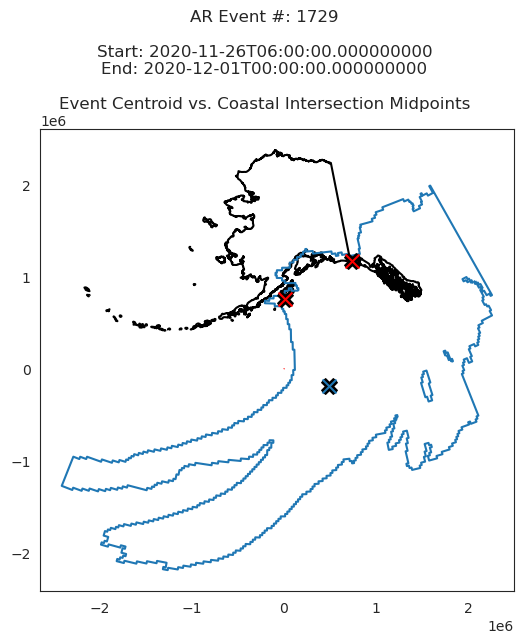

In [79]:
#plot whole AR centroid vs. coastal AR midpoints

#Haines 2020 AR event number
e = 1729
d1 = str(gdf_3338[gdf_3338['event_id']==e]['start'].values[0])
d2 = str(gdf_3338[gdf_3338['event_id']==e]['end'].values[0])

fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
ak_coast.plot(color='red', linewidth=1, ax=ax, zorder=1.5)

gdf_3338.loc[gdf_3338['event_id']==e].boundary.plot(ax=ax, zorder=2)
gdf_3338.loc[gdf_3338['event_id']==e,'geometry'].centroid.plot(ax=ax, color='black', markersize=125, marker='X', zorder=3)
gdf_3338.loc[gdf_3338['event_id']==e,'geometry'].centroid.plot(ax=ax, markersize=100, marker='x', zorder=4)

gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='red', zorder=5)
gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='black', markersize=125, marker='X', zorder=6)
gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='red', markersize=100, marker='x', zorder=7)

fig.suptitle(("AR Event #: " + str(e) + "\n\nStart: " + d1 + "\nEnd: " + d2 + "\n\nEvent Centroid vs. Coastal Intersection Midpoints"), y=1.08)